In [1]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import os 
from os.path import join
import glob
from math import factorial
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
from torch.nn.utils import weight_norm

from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")
import itertools
from csv import DictWriter

<class 'torch.cuda.FloatTensor'>


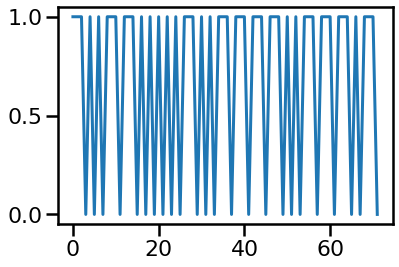

In [3]:
def generate_noise():
    """Generates dot and dash based noise."""
    
    threes = np.random.randint(8, 14)
    ones = (18 - threes) * 2
    noise = list(itertools.repeat([1,1,1,0], threes))
    noise.extend(list(itertools.repeat([1,0], ones)))
    random.shuffle(noise)
    noise = np.concatenate(noise)
    return noise
noise = generate_noise()
plt.plot(noise)


In [4]:
sig_lets = ["A","B","C","D","E","F","G","H",]

signals = ttype([[0,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,0],
                 [0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0]]
               ).view(8, 1, 1, -1)
#signals = ms
key2id = {k:i for i, k in enumerate(sig_lets)}

print(key2id)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}


In [5]:
torch.manual_seed(12345)
training_samples = 32

training_signals = []
training_class = []

for i, sig in enumerate(signals):
    temp_signals = []
    temp_class = []
    for x in range(training_samples):
        noise = ttype(generate_noise())
        temp = torch.cat([sig[0,0], noise]).unsqueeze(0)
        while(any([(temp == c_).all() for c_ in temp_signals])):
            print('SHIT')
            noise = ttype(generate_noise())
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0)
        temp_signals.append(temp)
        temp_class.append(i)
    training_signals.extend(temp_signals)
    training_class.extend(temp_class)

batch_rand = torch.randperm(training_samples*signals.shape[0])        
training_signals = torch.cat(training_signals).cuda().unsqueeze(-1)[batch_rand]
training_class  = ctype(training_class).cuda().unsqueeze(-1)[batch_rand]

dataset = torch.utils.data.TensorDataset(training_signals, training_class)
dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)



In [6]:
b = next(enumerate(dataset))[1]
print(b[0].shape, b[1].shape)

torch.Size([32, 89, 1]) torch.Size([32, 1])


In [9]:
testing_samples = 10
testing_signals = []
testing_class = []

for i, sig in enumerate(signals):
    temp_signals = []
    temp_class = []
    for x in range(testing_samples):
        noise = ttype(generate_noise())
        temp = torch.cat([sig[0,0], noise]).unsqueeze(0)
        while(any([(temp == c_).all() for c_ in temp_signals]) or any([(temp == c_).all() for c_ in training_signals])):
            print('SHIT')
            noise = ttype(generate_noise())
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0)
        temp_signals.append(temp)
        temp_class.append(i)
    testing_signals.extend(temp_signals)
    testing_class.extend(temp_class)
batch_rand = torch.randperm(testing_samples*signals.shape[0])

testing_signals = torch.cat(testing_signals).cuda().unsqueeze(-1)[batch_rand]
testing_class  = ctype(testing_class).cuda().unsqueeze(-1)[batch_rand]


dataset_valid = torch.utils.data.TensorDataset(testing_signals, testing_class)
dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=False)


In [17]:
inp = next(enumerate(dataset_valid))[1][0]

In [10]:
class LSTM_Predictor(nn.Module):
    def __init__(self, out_features, lstm_params):
        super(LSTM_Predictor, self).__init__()
        self.lstm = nn.LSTM(**lstm_params)
        self.to_out = nn.Linear(lstm_params['hidden_size'], 
                                out_features)
    def forward(self, inp):
        x = self.lstm(inp)[0].transpose(1,0)
        x = torch.tanh(self.to_out(x))
        return x

In [30]:
def train(model, ttype, train_loader, test_loader, optimizer, loss_func, epoch, perf_file,
          permute=None, loss_buffer_size=64, batch_size=4, device='cuda',
          prog_bar=None):
    
    assert(loss_buffer_size%batch_size==0)
        
    losses = []
    perfs = []
    last_test_perf = 0
    best_test_perf = -1
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data = data.to(device).transpose(1,0)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_func(out[:, -1, :],
                         target[:, 0])
        
        loss.backward()
        optimizer.step()

        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      target[:, 0]).sum().item())
        perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        losses = losses[int(-loss_buffer_size/batch_size):]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.4f}, perf: {:.4f}, valid: {:.4f}"
            format_list = [e,batch_idx*batch_size, np.mean(losses), 
                           np.sum(perfs)/((len(perfs))*batch_size), last_test_perf]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            last_test_perf = test(model, 'cuda', test_loader, 
                                  batch_size=batch_size, 
                                  permute=permute)
            loss_track['avg_loss'] = np.mean(losses)
            loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            loss_track['train_perf']= np.sum(perfs)/((len(perfs))*batch_size)
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
                fp.flush()
            if best_test_perf < last_test_perf:
                torch.save(model.state_dict(), perf_file[:-4]+".pt")
                best_test_perf = last_test_perf

                
def test(model, device, test_loader, batch_size=4, permute=None):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device).transpose(1,0)
            target = target.to(device)
            
            out = model(data)
            pred = out[:, -1, :].argmax(dim=-1, keepdim=True)
            
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += 1
    return correct / len(test_loader.dataset)

# Training and testing

In [31]:
# You likely don't need this to be this long, but just in case.
epochs = 1000

# Just for visualizing average loss through time. 
loss_buffer_size = 100

In [38]:
lstm_params = dict(input_size=1,
                   hidden_size=36, 
                   num_layers=3)
model = LSTM_Predictor(8, lstm_params=lstm_params).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)
model(inp.transpose(1,0)).shape

Total Weights: 27224
LSTM_Predictor(
  (lstm): LSTM(1, 36, num_layers=3)
  (to_out): Linear(in_features=36, out_features=8, bias=True)
)


torch.Size([32, 89, 8])

In [ ]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1000
batch_size = 32
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, dataset, dataset_valid, 
          optimizer, loss_func, batch_size=batch_size,
          epoch=e, perf_file=join('perf','h8_lstm_2.csv'),
          prog_bar=progress_bar)

In [24]:
import matplotlib.pylab as plt
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sn
sn.set_context('talk')

In [29]:
dat = pd.read_csv(os.path.join('perf', 'h8_cornn_2.csv'))
maxpres = 6*32
dat['presnum_epoch'] = ((dat.batch_idx*32) + maxpres*dat.epoch)/maxpres


In [30]:
dat.shape

(3000, 6)

(0.0, 1.2)

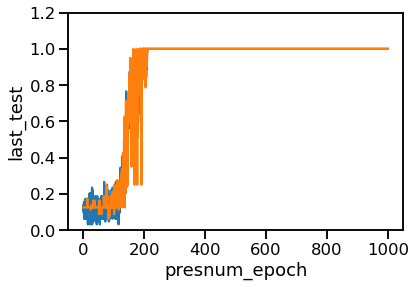

In [31]:
sn.lineplot(data=dat, x='presnum_epoch', y='train_perf', 
            )
sn.lineplot(data=dat, x='presnum_epoch', y='last_test', 
            )
plt.ylim(0,1.2)